# Example use of implemented conductance models

In this notebook, we show how the ionospheric conductances (height integrated conductivities) can be found using implementations of:

- The [Hardy et al. (1987)](https://doi.org/10.1029/JA092iA11p12275) model for auroral contribution to conductances - `hardy()`.
- A novel method to calculate the solar extreme ultraviolet (EUV) contribution to the ionospheric conductance - `EUV_conductance()` (the method is described in Section 2.4 in [Laundal et al., 2022](https://doi.org/10.1029/2022JA030356)). 

The total ionospheric conductances are a combination of the contribution from solar EUV radiation and the ionizing auroral precipitation. The `hardy_EUV()` function uses the above functions to obtain the total ionospheric conductances.

We will plot the ionospheric conductances on polar axes defined by magnetic latitude and local time coordinates (described further in Notebook 05).

We start by importing relevant modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import lompe
from lompe.utils.conductance import *
from lompe.polplot import Polarplot
from lompe.dipole import Dipole

time = dt.datetime(2015, 7, 2, 11, 50) # date is used for coordinate conversion and to get solar zenith angles (sza)

We want to find the ionospheric conductances for the entire northen hemisphere above 50$^\circ$ magnetic latitude. We therefore make a set of magnetic latitude and magnetic local time (MLT) coordinates covering a large portion of the high-latitude northern hemisphere:

In [2]:
mlats = np.linspace(50, 90, 37)
mlts = np.linspace(0, 24, 72)
mlat, mlt = np.meshgrid(mlats, mlts, indexing='xy')

We can then use the `hardy_EUV` function to get the total conductances (both auroral "Hardy conductances" and solar EUV contribution to the condutances) for these locations. We specify that we want sunlight as for 2 July 2015 at 11:50 UT and auroral patterns from the Hardy model for a Kp index of 4. We also specify an F10.7 index which is used in calculations for the solar contribution to the ionospehric conductances.

In [3]:
Kp   = 4    # for Hardy model
F107 = 100  # for EUV conductance                 

# coordinates are converted to geographic system
cd = Dipole(time.year)
mlon = cd.mlt2mlon(mlt, time) # get magnetic longitude

# Hall and Pedersen conductances
SH, SP = hardy_EUV(mlon, mlat, Kp, time, 'hp', F107=F107, dipole=True)

The `hardy_EUV()` fucntion can also return only the Hall, or only the Pedersen conductance by specifying the `hall_or_pedersen` keyword to either `hall/h` or `pedersen/p`. An additional input parameter of `calibration` can be given, which is relevant for how the EUV contribution to the conductances is calculated (this is explained further in  the last part of this notebook, under *Example to look at differences in `calibration`*).

### `polplot` for visualization

We show the ionospheric conductances on the nortern hemisphere using a `polplot.Polarplot` object (a polar axis). `Polarplot` objects handle plotting in polar coordinates, specificall a latitude/local time grid. The conductances are defined in centered dipole magnetic latitude and MLT.

In [4]:
def make_cond_figure(mlat, mlt, SH, SP, levels=np.linspace(0,20,20), ticks=np.linspace(0,20,5), 
                     savefig = False, header=None, **latargs):
    """ plots Hall and Pedersen conductances on polar (MLAT/MLT) axes"""
    
    # set up figure and axes
    fig = plt.figure(figsize = (11,5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    ax1.set_title('Hall',     y=1, fontsize=16)
    ax2.set_title('Pedersen', y=1, fontsize=16)
    
    # initialize Polarplot objects and add axis labels
    polplot1 = Polarplot(ax1, minlat=50, plotgrid=True, sector='all')
    polplot2 = Polarplot(ax2, minlat=50, plotgrid=True, sector='all')
    polplot1.writeLTlabels(color='grey', lat=50, fontsize=12)
    polplot2.writeLTlabels(color='grey', lat=50, fontsize=12)
    polplot1.writeLATlabels(**latargs)
    polplot2.writeLATlabels(**latargs)

    # conductances
    c=polplot1.contourf(mlat, mlt, SH.reshape(mlat.shape), cmap='magma', levels=levels, extend='both')
    polplot2.contourf(  mlat, mlt, SP.reshape(mlat.shape), cmap='magma', levels=levels, extend='both')
    
    # adjust spacing between axes
    plt.subplots_adjust(wspace=0.09, left=0.01, right=1.1, bottom=0 , top=.9)

    # color bar
    cbar=fig.colorbar(c, ax=[ax1,ax2], ticks=ticks, orientation='vertical', shrink=0.7, aspect=25)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel('[moh]', fontsize=16)

    # add header
    if header is not None:
        fig.suptitle(header, fontweight="bold", fontsize=16, x=.44, y=.995)

    # save figure
    if savefig:
        fig.savefig('./output_figures/04conductanceexample.pdf')
        fig.savefig('./output_figures/04conductanceexample.png')

Make figure for ionospheric conductances from `hardy_EUV`:

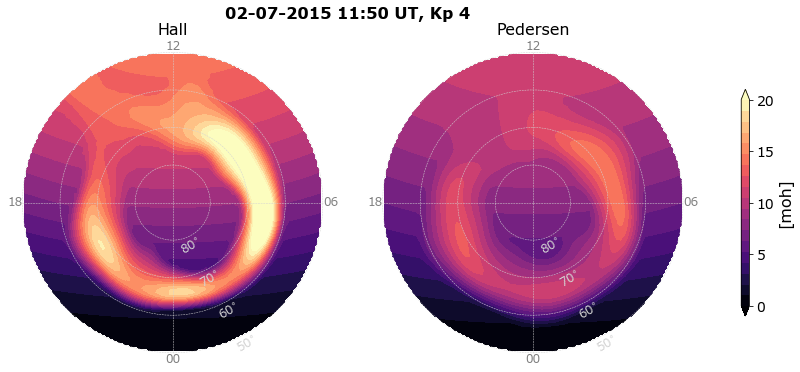

In [5]:
latargs = {'color':'lightgrey', 'lt':2 , 'fontsize':12, 'backgroundcolor':'#0f0f0f00', 'ha':'center', 'va':'top', 'rotation':30}
header = time.strftime("%d-%m-%Y %H:%M UT")+""", Kp """+str(Kp)
make_cond_figure(mlat, mlt, SH, SP, header=header, savefig=True, **latargs)

### Hardy model for auroral conductances
    
We can get the auroral contribution to the ionospheric conductance only using the implementation of the [Hardy et al. (1987)](https://doi.org/10.1029/JA092iA11p12275) model. The `hardy()` function returns only the empirical patterns from the [Hardy et al. (1987)](https://doi.org/10.1029/JA092iA11p12275) model, and requires the Kp index, as the empirical patterns of auroral conductances are binned based on Kp (0-6). In this example, we use Kp 4. Note that the implementation of the Hardy model requires the locations to be given in magnetic latitude (CGM, same as centered dipole at high latitudes) and MLT coordinates.

In [6]:
hardy_hall, hardy_pedersen = hardy(mlat, mlt, Kp, 'hp') # or one or the other using hallOrped keyword ('h' or 'p')

Plot the auroral conductances only:

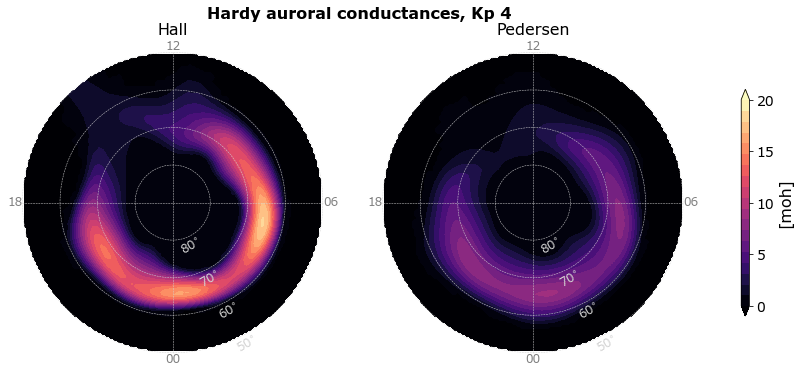

In [7]:
header = """    Hardy auroral conductances, Kp """+str(Kp)
make_cond_figure(mlat, mlt, hardy_hall, hardy_pedersen, header=header, **latargs)

### EUV conductances

If we want only the solar EUV contribution to the conductance, we use the `EUV_conductance()` function. This function is based on a modified version of the empirical model from [Moen and Brekke (1993)](https://doi.org/10.1029/92GL02109) where $cos\chi$ is replaced with a function $q'(\chi)$ that specifies the relative maximum production due to solar EUV assuming a radially stratified atmosphere (i.e., accounting for the fact that the Earth is round). $\chi$ is the solar zenith angle. We get solar zenith angles for 2 July. A file containing $q'(\chi)$ for all $\chi$ between 0$^\circ$ and 120$^\circ$ (0.1$^\circ$ resolution) stored in the *lompe/data/* folder is used for the calculations. With `calibration='Cousinsetal2015'`, a modified version of the emprical conductance model from [Cousins et al. (2015)](https://doi.org/10.1002/2014JA020463) is used to calculate the conductances. 

To get only solar EUV contribution to the ionospheric conductance:

In [8]:
lat, lon = cd.mag2geo(mlat, mlon)
sza = lompe.utils.sunlight.sza(lat, lon, time)                # get sza for geographic locations

EUV_SH, EUV_SP = EUV_conductance(sza, F107, 'hp') # or one or the other using hallOrped ('h' or 'p')

Plot the EUV conductances:

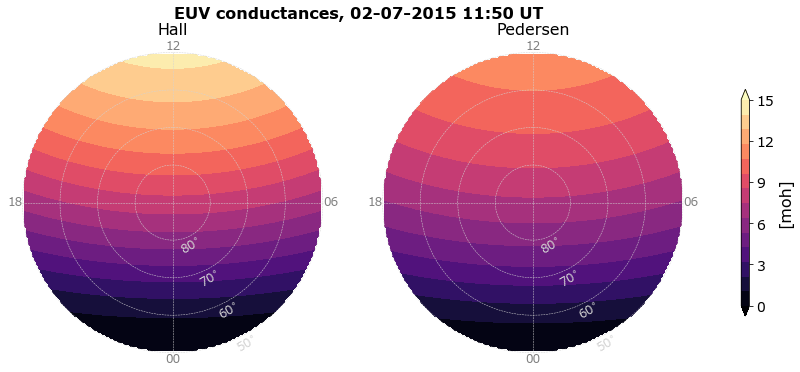

In [9]:
header = """    EUV conductances, """+time.strftime("%d-%m-%Y %H:%M UT")
levels = np.linspace(0,15,15)
ticks  = np.linspace(0,15,6)
make_cond_figure(mlat, mlt, EUV_SH, EUV_SP, levels=levels, ticks=ticks, header=header, **latargs)

Note that we indicate the full date and the universal time in the header, as this is relevant for the magentic systems orientation with respect to the sun.

### Example to look at differences in `calibration`

Different empirical models for the EUV conductance exist, and which `calibration` that is the best can be hard to determine. This has been pointed out by, e.g., [Ieda et al. (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JA020665), and D. R. Weimer in a talk titled [Unsolved Problems In Ionospheric Conductivity](http://spacescience.org/workshops/unsolvedproblems2015/presentations/dan_weimer.pdf) held in 2015. Therefore we include at least two alternative empirical models (*calibrations*) in our implementation.

We can compare the different empirical models:

In [10]:
# using the empirical model from Cousins et al. (2015)
SH_C, SP_C     = EUV_conductance(sza, F107, 'hp', calibration = 'Cousinsetal2015'   )
# using the empirical model from Moen & Brekke (1993) but with "alternative" coefficients
SH_alt, SP_alt = EUV_conductance(sza, F107, 'hp', calibration = 'MoenBrekke1993_alt')

And plot the EUV conductances for different calibrations:

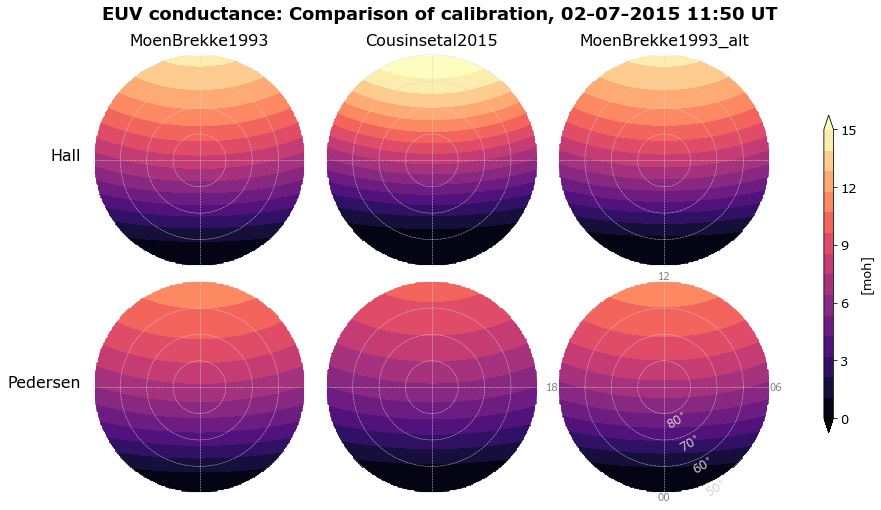

In [11]:
# set up figure and axes
fig = plt.figure(figsize=(11,7))
fig.suptitle("""EUV conductance: Comparison of calibration, """+time.strftime("%d-%m-%Y %H:%M UT"), 
             fontweight="bold", fontsize = 18, x=.45)
axs = [fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233), fig.add_subplot(234), 
       fig.add_subplot(235), fig.add_subplot(236)]

paxs = []
for ax in axs:
    paxs.append(Polarplot(ax, minlat = 50))
paxs[-1].writeLTlabels( color='grey',     lat = 50)
paxs[-1].writeLATlabels(**latargs)

# conductances from the different calibrations
plotargs = {'cmap':'magma', 'levels':np.linspace(0,15,15), 'extend':'both'}

# Hall
paxs[0].contourf(mlat, mlt, EUV_SH.reshape(mlat.shape), **plotargs) # moenbrekke1993
paxs[1].contourf(mlat, mlt, SH_C.reshape(  mlat.shape), **plotargs) # cousinsetal2015
paxs[2].contourf(mlat, mlt, SH_alt.reshape(mlat.shape), **plotargs) # moenbrekke993_alt

# Pedersen
paxs[3].contourf(  mlat, mlt, EUV_SP.reshape(mlat.shape), **plotargs) # moenbrekke1993
paxs[4].contourf(  mlat, mlt, SP_C.reshape(  mlat.shape), **plotargs) # cousinsetal2015
c=paxs[5].contourf(mlat, mlt, SP_alt.reshape(mlat.shape), **plotargs) # moenbrekke993_alt

# add titles and adjust
paxs[0].text(45, 18, text='Hall',     ignore_plot_limits = True, fontsize = 16, ha = 'right')
paxs[3].text(45, 18, text='Pedersen', ignore_plot_limits = True, fontsize = 16, ha = 'right')
axs[0].set_title('MoenBrekke1993'    , y = 0.98, fontsize = 16)
axs[1].set_title('Cousinsetal2015'   , y = 0.98, fontsize = 16)
axs[2].set_title('MoenBrekke1993_alt', y = 0.98, fontsize = 16)
plt.subplots_adjust(hspace=0, wspace=0, left=0, right=1.1, bottom=0 ,top=.9);

# colorbar
ticks = np.linspace(0,15,6)
cbar = fig.colorbar(c, ax = axs, ticks=ticks, orientation = 'vertical', shrink=.7, aspect=30)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_ylabel('[moh]', fontsize=13);

Where the magnetic latitude and MLT labels are in the lower right hand panel.